<img src="4.1.png">
The nonterminal states are S = {1, 2,..., 14}. There are four actions possible in each
state, A = {up, down, right, left}, which deterministically cause the corresponding
state transitions, except that actions that would take the agent off the grid in fact leave
the state unchanged. Thus, for instance, p(6, 1|5, right) = 1, p(7, 1|7, right) = 1,
and p(10, r|5, right) = 0 for all r $\in$ R. This is an undiscounted, episodic task. The
reward is -1 on all transitions until the terminal state is reached. The terminal state is
shaded in the figure (although it is shown in two places, it is formally one state). The
expected reward function is thus r(s, a, s') = 1 for all states s, s' and actions a. Suppose
the agent follows the equiprobable random policy (all actions equally likely). The left side
of Figure 4.1 shows the sequence of value functions {v$_{k}$} computed by iterative policy
evaluation. The final estimate is in fact v$_{\pi}$, which in this case gives for each state the
negation of the expected number of steps from that state until termination.

In [138]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.table import Table

In [139]:
class Agent:
    
    def __init__(self, actions):
        self.actions = actions 
        
    def step(self, env, state, V):
        """
        Agent Steps through environment receives observation
        Updates V based on observation returned from environment
        """
        
        # Start from 0 to estimate neighbor states
        value = 0
        
        # Test all actions and bootstrap update
        for action in self.actions:
            
            # Action index 
            a = self.actions.index(action)
            
            # Get all next states and rewards
            s_prime, reward = env.observation(state, action)

            # V(s) <-- [r + *V(s')] undiscounted and bootstrapping all next states
            value += env.policy[state][a] * (reward + env.gamma*V[s_prime])
        
        # Update value function
        V[state] = value
        
    def q_greedy(self, env, V, pi, state):
        """
        Make policy greedy W.R.T. argmax q(s,a) 
        """

        q = [0] * len(self.actions)

        # Iterate through actions in state s
        for action in self.actions:
            
            # action index
            a = self.actions.index(action)
            
            # Get all next states and rewards
            s_prime, reward = env.observation(state, action)

             # q
            q[a] += (reward + env.gamma*V[s_prime])

        # Argmax of p(s',r|s,a)[r + g*V(s')]
        pi[state] = [0 for _ in pi[state]]
        pi[state][q.index(max(q))] = 1

In [140]:
class Environment:
    
    def __init__(self, width, probability, reward, gamma, height = 0):
        self.width = width
        self.height = width if height < 1 else height 
        self.length = self.width*self.height
        self.probability = probability
        self.policy, self.V = self.create()
        self.reward = reward
        self.gamma = gamma
    
    def create(self):
        """
        Create initial value function V and policy pi
        """
        
        policy = {}; V = {}
        
        # Create states for policy
        for i in range(self.length):

            # Create row index
            row = i // self.height

            # Create column index
            column = i % self.width

            # Create policy
            policy[(row, column)] = self.probability

            # Initialize V (s), for all s in S+, arbitrarily except that V (terminal)=0
            V[(row, column)] = 0

        # Remove Terminal states from policy
        del policy[(0, 0)]
        del policy[(self.height-1, self.width-1)]
        
        return policy, V
        
    def observation(self, state, action):
        """
        Return environment obervation
        """

        # S' after a
        s_prime = (state[0] + action[0], state[1] + action[1])

        # row boundary
        row_boundary = (s_prime[0] < 0 or s_prime[0] > self.height-1) 

        # column boundary
        column_boundary = (s_prime[1] < 0 or s_prime[1] > self.width-1) 

        # check if out of bounds
        if row_boundary or column_boundary:

            # Remain in state
            s_prime = state

        # S', R'
        return s_prime, self.reward

In [141]:
def policy_evaluation(env, agent, theta=0.01):
    """
    Evaluates V returns v_pi
    """
    
    # Input Policy
    policy = env.policy
    
    # Value function
    V = env.V
    
    # Algorithm parameter: a small threshold ✓ > 0 determining accuracy of estimation
    delta = theta

    # Loop: until delta < ✓
    while delta >= theta:

        # delta <-- 0
        delta = 0

        # Loop for each state:
        for state, actions in policy.items():

            # v <-- V(s)
            v = V[state]

            # Reset value for summation
            value = 0
            
            # Bellman optimality update 
            agent.step(env, state, V)

            # delta <-- max(delta, |v - V(s)|)
            delta = max(delta, abs(v-V[state]))
    
    # return v_pi
    return V

In [142]:
def policy_improvement(env, agent, V, pi):
    """
    Improve policy and return v* and pi*
    """
    # policy stable 
    policy_stable = True

    # Loop for each s in S
    for state in env.policy:

        # old-action <-- pi(s)
        old = pi[state]

        # argmax 
        agent.q_greedy(env, V, pi, state)
        
        # test if policy stable
        if old != pi[state]: policy_stable = False
    
    # Policy stable return v* and pi*
    return pi, policy_stable

In [143]:
def policy_iteration(env, agent):
    """
    Improve policy and return v* and pi*
    """
    
    # V 
    V = env.V.copy()
    
    # policy 
    policy = env.policy.copy()
    
    # policy stable 
    policy_stable = False
    
    # Until stable
    while not policy_stable:  
            
        # policy evaluation
        V = policy_evaluation(env, agent)
        
        # policy improvement
        policy, policy_stable = policy_improvement(env, agent, V, policy)
    
    # Policy stable return v* and pi*
    return V, policy

In [144]:
def draw_grid(V):
    """
    Draws GridWorld image
    """
    
    ########
    # Plot #
    ########
    fig, ax = plt.subplots(figsize=(15,15))
    ax.set_axis_off()
    tb = Table(ax)

    # Create cells in table/grid
    for (i, j), value in V.items():

        # convert to string
        value = str(round(value))

        # Create cell
        tb.add_cell(i, j, 1/5, 1/5, text=value,
                loc='center', facecolor='white')

    # Create the table
    ax.add_table(tb)

In [145]:
def draw_policy(pi, arrows):
    """
    Draws GridWorld policy image
    """
    
    ########
    # Plot #
    ########
    fig, ax = plt.subplots(figsize=(15,15))
    ax.set_axis_off()
    tb = Table(ax)
    
    value = ""
    
    # Create cells in table/grid
    for (i, j), values in pi.items():
    
        # convert to string
        value = arrows[np.argmax(pi[(i, j)])]

        # Create cell
        tb.add_cell(i, j, 1/4, 1/4, text=value,
                loc='center', facecolor='white')

    # Create the table
    ax.add_table(tb)

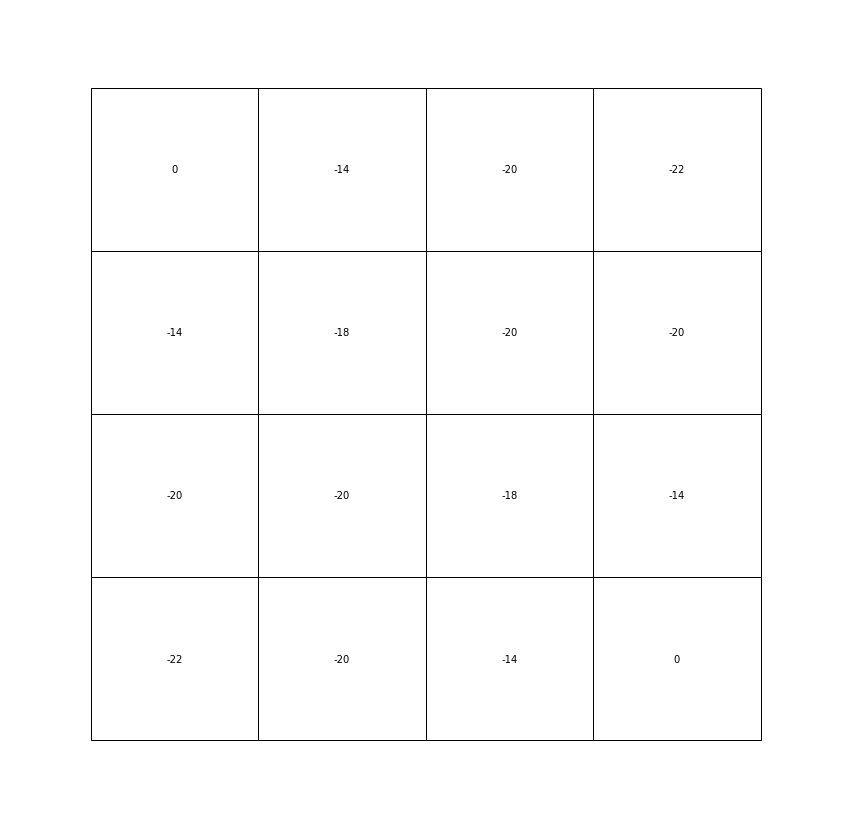

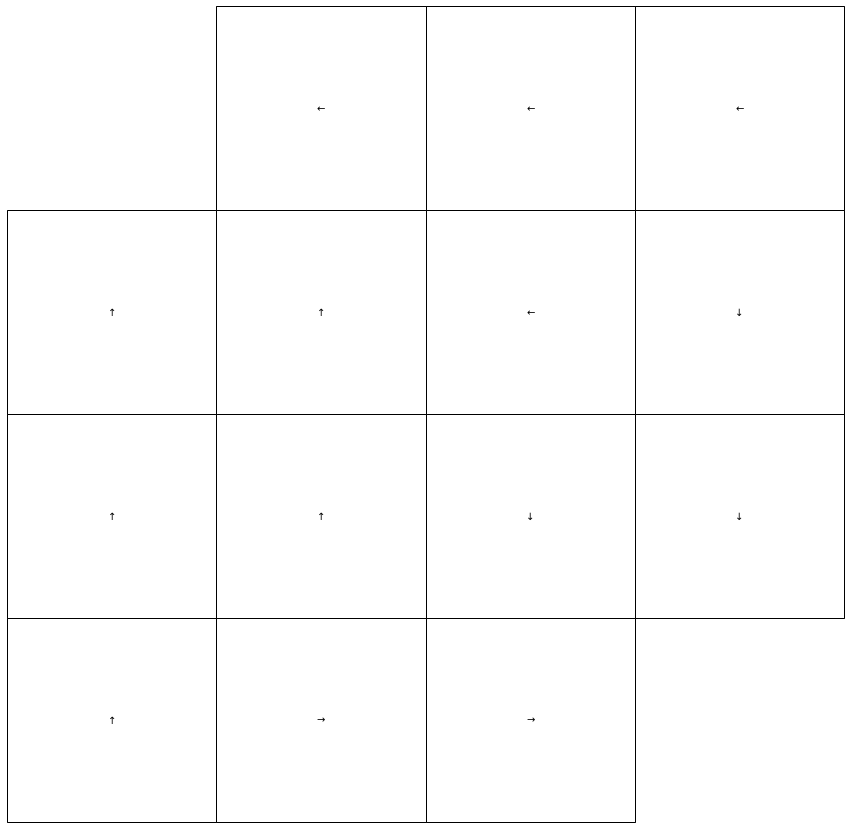

In [146]:
if __name__ == "__main__":
    
    # Action probabilities
    p = [0.25, 0.25, 0.25, 0.25]
    
    # Actions: [(-1, 0), (1, 0), (0, 1), (0, -1)]
    a = [(-1, 0), (1, 0), (0, 1), (0, -1)]
    
    # Arrows for plotting
    arrows = [ '↑', '↓', '→', '←']
    
    # Environment
    env = Environment(width=4, probability=p, reward=-1, gamma=1)
    
    # Agent
    agent = Agent(a)
    
    # Policy evaluation = v_pi
    v, pi = policy_iteration(env, agent)
    
    # Draw GridWorld
    draw_grid(v)
    
    # Draw GridWorld
    draw_policy(pi, arrows)